<a href="https://colab.research.google.com/github/wdconinc/practical-computing-for-scientists/blob/master/Lectures/lecture11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lecture #11

##Standard Preamble

In [0]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

##In our last episode

* Numerical derivatives. 
  * Accuracy: truncation error and roundoff error.
  * One weird trick involving h
* Root finding
  * Plotting and counting
  * Bracketing roots
  * Polishing: Bisection method

## Numerical Derivatives

In [0]:
def D(f, h = 1.0e-6):
    ''' computes the derivative df/dx '''
    return lambda x: (f(x+h) - f(x-h)) / (2.0*h)

In [0]:
x = np.linspace(-3.14,+3.14)
f = lambda x: np.sin(x)
df = lambda x: np.cos(x)
ddf = lambda x: -np.sin(x)
dddf = lambda x: -np.cos(x)
ddddf = lambda x: np.sin(x)


###D(f,x) - df(x) and the choice of h

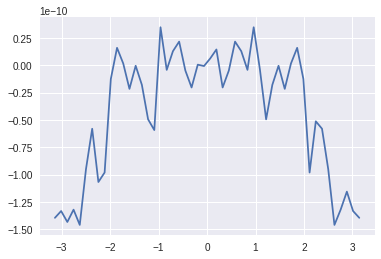

In [0]:
plt.plot(x,D(f)(x) - df(x))

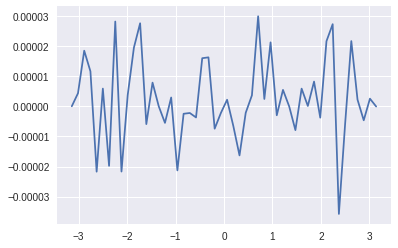

In [0]:
plt.plot(x,D(D(f))(x) - ddf(x))

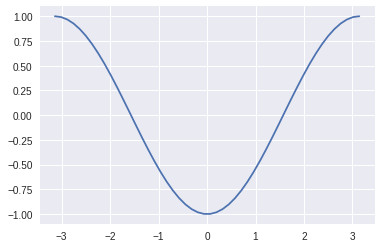

In [0]:
plt.plot(x,dddf(x))

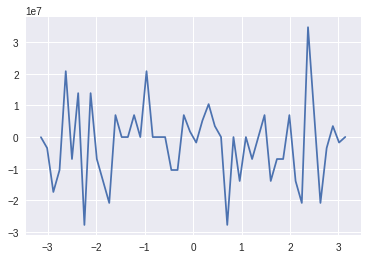

In [0]:
plt.plot(x,D(D(D(D(f))))(x) - ddddf(x))

##Root Finding

###Plot the Function

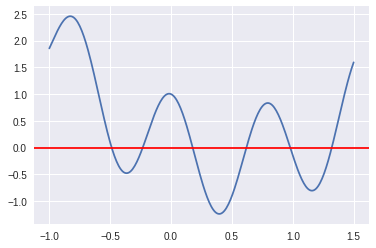

In [0]:
g = lambda x: np.cos(8*x) + x**2 - x
x = np.linspace(-1, 1.5, 300)
plt.plot(x, g(x))
plt.axhline(y = 0.0, color ='red')

###An algorithm to bracket the roots

In [0]:
def bracket_roots(f,xlow,xhigh,n=100):
    result = []
    dx = (xhigh - xlow) / float(n)
    for i in range(0,n):
        a = xlow + dx * i
        b = a + dx
        if f(a)*f(b) < 0.0:
            result.append((a,b))
    return result

brackets = bracket_roots(g, -1.0, 1.5)
print(brackets)

[(-0.5, -0.475), (-0.25, -0.225), (0.17500000000000004, 0.20000000000000004), (0.6000000000000001, 0.6250000000000001), (0.9750000000000001, 1.0), (1.3000000000000003, 1.3250000000000002)]


###Root polishing - Bisection method

In [0]:
def bisection(f, xlow, xhigh, accuracy = 1e-6, nmax = 100):
    if xlow > xhigh:
        raise RuntimeError('xlow > xhigh')
    flow = f(xlow)
    fhigh = f(xhigh)
    for i in range(0, nmax):
        xmid = (xlow + xhigh) / 2.0
        fmid = f(xmid)
        if fmid == 0 or math.fabs(xhigh - xlow) < accuracy:
            return xmid, i
        if fmid*fhigh < 0:
            xlow, flow = xmid, fmid
        else:
            xhigh, fhigh = xmid, fmid
    
for xlow, xhigh in brackets:
    root, k = bisection(g, xlow, xhigh)
    print("found root %f between [%f,%f] in %i iterations" % (root, xlow, xhigh, k))

found root -0.487603 between [-0.500000,-0.475000] in 15 iterations
found root -0.232721 between [-0.250000,-0.225000] in 15 iterations
found root 0.177995 between [0.175000,0.200000] in 15 iterations
found root 0.618814 between [0.600000,0.625000] in 15 iterations
found root 0.979202 between [0.975000,1.000000] in 15 iterations
found root 1.319947 between [1.300000,1.325000] in 15 iterations


How many iterations do we expect to reach an accuracy of $1 \times 10^{-6}$?

In [0]:
math.log((0.025) / 1e-6, 2)

14.609640474436812

### The secant method

<img src="https://upload.wikimedia.org/wikipedia/commons/4/40/Secant_method_2.svg">

In [0]:
def secant(f, xlow, xhigh, accuracy = 1e-6, nmax = 100):
    xlast = xlow # x_i-1
    x = xhigh # x_i
    for i in range(0, nmax):
        fx = f(x)
        flast = f(xlast)
        slope = (fx - flast) / (x - xlast)
        dx = -flast / slope
          #print("i:%i, xl:%g x%g fx:%g fl:%g dx:%g" % (i, xlast, x, fx,flast, dx))
        x, xlast = xlast + dx, x
        if math.fabs(x - xlast) < accuracy:
            return x, i
    raise ArithmeticError('failed to converge')

for xlow, xhigh in brackets:
    root, k = secant(g, xlow, xhigh)
    print("found root %f between [%f,%f] in %i iterations" % (root, xlow, xhigh, k))
        

found root -0.487604 between [-0.500000,-0.475000] in 3 iterations
found root -0.232720 between [-0.250000,-0.225000] in 3 iterations
found root 0.177995 between [0.175000,0.200000] in 2 iterations
found root 0.618815 between [0.600000,0.625000] in 2 iterations
found root 0.979202 between [0.975000,1.000000] in 2 iterations
found root 1.319947 between [1.300000,1.325000] in 3 iterations


#### But careful...

<img src="https://upload.wikimedia.org/wikipedia/commons/9/92/Secant_method.svg">

###Brent's method (via scipy)

In [0]:
import scipy.optimize as op

for xlow, xhigh in brackets:
    root = op.brentq(g, xlow, xhigh, xtol = 1e-6)
    print("found root %f between [%f,%f]" % (root, xlow, xhigh))

found root -0.487604 between [-0.500000,-0.475000]
found root -0.232720 between [-0.250000,-0.225000]
found root 0.177995 between [0.175000,0.200000]
found root 0.618814 between [0.600000,0.625000]
found root 0.979202 between [0.975000,1.000000]
found root 1.319947 between [1.300000,1.325000]


###Newton-Raphson Method

If we know the analytical derivative of the function, we can use that information.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/22/Newton_method_scheme.svg">

In [0]:
def newton(f, df, xlow, xhigh, accuracy = 1e-6, nmax = 100):
    xlast = xlow
    x = xhigh
    for i in range(0,nmax):
        fx = f(x)
        slope = df(x)
        dx = -fx / slope
        x, xlast = x + dx, x
        if math.fabs(x - xlast) < accuracy:
            return x, i
    
  dg = lambda x: -8*np.sin(8*x) + 2*x - 1

for xlow, xhigh in brackets:
    root, i = newton(g, D(g), xlow, xhigh)
    print("found root %f between [%f,%f] in %i iterations" % (root, xlow, xhigh, i))

found root -0.487604 between [-0.500000,-0.475000] in 3 iterations
found root -0.232720 between [-0.250000,-0.225000] in 2 iterations
found root 0.177995 between [0.175000,0.200000] in 2 iterations
found root 0.618815 between [0.600000,0.625000] in 2 iterations
found root 0.979202 between [0.975000,1.000000] in 2 iterations
found root 1.319947 between [1.300000,1.325000] in 2 iterations


http://doodle.com/wdeconinck


In [0]:
f = lambda x: np.sin(x)
df = lambda x: np.cos(x)

root = op.brentq(f, 3.0, 3.2, xtol = 1e-10)
print("found root %f between [%f,%f]" % (root, xlow, xhigh))

found root 3.141593 between [1.300000,1.325000]


##Multiple dimensions

###How to plot a 2D scalar function

###How to find the root?